# 2CS-SIL2/SIQ2 Lab05. Support Vectors Machines and optimization

<p style='text-align: right;font-style: italic;'>Designed by: Mr. Abdelkrime Aries</p>

In this lab, we will learn about two concpts:
- Support Vectors Machines (primal and dual forms)
- Optimization (stochastic gradient descent and Sequential minimal optimization)

**Team:**
- **Member 01**: Amoura Yousra
- **Member 02**: Ouadi Amina Tinhinene
- **Group**: SIL2/SIQ2

In [ ]:
import matplotlib
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('2.0.2', '2.2.2', '3.10.0')

In [ ]:
from datetime import datetime
import random
import timeit
import sys

datetime.now()

datetime.datetime(2025, 5, 3, 17, 43, 14, 853537)

In [ ]:
import sklearn

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn import datasets

sklearn.__version__

'1.6.1'

In [ ]:
# Type hints
from typing          import Tuple, List, Type, Union, Literal, TypeAlias
from collections.abc import Callable

datetime.now()

datetime.datetime(2025, 5, 3, 17, 43, 24, 231441)

In [ ]:
# NB. Do not change.
# If you do, you'll get a Zoidberg (Futurama) face

# calculate the size of an object with these components
# code taken from this link
# https://stackoverflow.com/a/40880923/2296914
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

get_size({'a': 1, 'bb': 1.1})

337

## I. Algorithms implementation

In this section, we will try to implement multinomial Naive Bayes.

**>> Try to use "numpy" which will save a lot of time and effort**

### I.1. Primal SVM

Here, we will try to implement the primal form of SVMs for binary classification.
It is very similar to logistic regrssion.

#### I.1.1. Estimation function

The estimation function uses weighted sum to estimate the side (positive or negative):
$$ h^{(i)} = b + \sum_{j=1}^{N} w_j x_j^{(i)}
\;\;\;\;\;
H = \langle W, X\rangle + b
$$

with $(i)$ the ith sample

In [ ]:
# TODO: Primal SVM estimation function
def h_primal(X: np.ndarray[float, float],
             W: np.ndarray[float]   = None,
             b: float               = 0
             ) -> np.ndarray[float]:
    H = X.dot(W) + b
    return H

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array([-0.5,  1. ,  2.5])
#---------------------------------------------------------------------

X_t     = np.array([[2. , -10. ],
                    [1. , - 2. ],
                    [1.5,   3. ]])
w_t = np.array([ 0.5,   0.25])
b_t = 1.
H       = h_primal(X_t, w_t, b_t)
H

array([-0.5,  1. ,  2.5])

#### I.1.2. Cost function

We will implement soft margin using **Hinge** cost function:
$$\zeta^{(i)} = \max(0, 1- y^{(i)} h^{(i)})$$
$$ J(Y, H) = \frac{1}{M} \left( \frac{||W||^2}{2} + C \sum\limits_{i=0}^{M} \zeta^{(i)} \right)$$
where:
- $M$: Number of samples with $(i)$ the ith sample
- $N$: Number of features
- $h^{(i)}$: the estimated direction of the ith sample
- $C$: is a hypr-paramter with two objectives; maximize the margin or minimize the number of errors. Modifying C means prefering one objevtive over the other.


In [ ]:
# TODO: Primal SVM cost
def J_primal(Y: np.ndarray[float],
             H: np.ndarray[float],
             W: np.ndarray[float],
             C:  float = 1.
             ) -> float:
    Hinge = np.maximum(0, 1 - Y * H)
    J = (1 / len(Y)) * (0.5 * np.dot(W, W) + C * np.sum(Hinge))
    return float(J)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 0.875
#---------------------------------------------------------------------

H_t = np.array([-1.5,  0.,  1.5])
Y_t = np.array([ 0. ,  1.,  1. ])
W_t = np.array([ 0.5 ,  1. ])

J_primal(Y_t, H_t, W_t, C=1.)

0.875

#### I.1.2. Gradient function

**Hinge** gradient is calculated as follows:
$$ \frac{\partial \zeta^{(i)}}{\partial w_j} =
\begin{cases}
0 & \text{if } y^{(i)} h^{(i)} \ge 1\\
- x^{(i)}_j y^{(i)} & \text{otherwise}
\end{cases}
\;\;\;\;\;
\frac{\partial \zeta^{(i)}}{\partial b} =
\begin{cases}
0 & \text{if } y^{(i)} h^{(i)} \ge 1\\
- y^{(i)} & \text{otherwise}
\end{cases}
$$

$$ \frac{\partial J}{\partial w_j} =
\frac{1}{M} \left( w_j + C \sum\limits_{i=1}^M \frac{\partial \zeta^{(i)}}{\partial w_j} \right)
\;\;\;\;\;
\frac{\partial J}{\partial b} =
\frac{C}{M} \sum\limits_{i=1}^M \frac{\partial \zeta^{(i)}}{\partial b}
$$

where:
- $M$: Number of samples, with $(i)$ is the ith sample
- $N$: Number of features
- $w_j$: is the feature $j$'s parameter
- $b$: is the bias
- $C$: is a hypr-paramters with two objectives; maximize the margin or minimize the number of errors. Modifying C means prefering one objective over the other.


**HINT**
```python
# A[M]  => A.reshape(-1, 1) = A'[M, 1]
# A[M]  => A[:, np.newaxis] = A'[M, 1]
# A[M, 1] => np.repeat(A, N, axis=1) = A'[M, N] (each row will have the same value for its columns)
# A[M, N] bool, B[M, N], C[M, N] => np.where(A, B, C) = D[M, N] a matrix having elements of B or C following the truth of A
```

In [ ]:
# TODO: Primal SVM gradient
def dJ_primal(Y: np.ndarray[float],
              H: np.ndarray[float],
              W: np.ndarray[float],
              X: np.ndarray[float, float],
              C: float = 1.
              ) -> Tuple[np.ndarray[float], float]:
    M = len(Y)
    cdt = Y * H < 1

    dH_dw = np.where(cdt.reshape(-1, 1), -X * Y.reshape(-1, 1), 0)
    dW = (1 / M) * (W + C * np.sum(dH_dw, axis=0))

    dH_db = np.where(cdt, -Y, 0)
    db = (C / M) * np.sum(dH_db)

    return dW, float(db)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([ 0.9, -1.4]), 0.4)
#---------------------------------------------------------------------

X_t = np.array([[1., -5.],
                [2., -4.],
                [3., -3.],
                [4., -2.],
                [5., -1.]])
H_t = np.array([-1.5, 1.5, 0.5, -0.5, 0.2])
Y_t = np.array( [-1. , -1., -1., -1., 1.])
W_t = np.array([ 0.5 ,  1. ])

dJ_primal(Y_t, H_t, W_t, X_t)

(array([ 0.9, -1.4]), 0.4)

#### I.1.3. Gradient descent variants

**>> Nothing to code here**

Here we implemented three variations of gradient descent:
- **GD**: The normal gradient descent with the subgradients of all samples. For each iteration, the parameters are updated using the average of the subgradients over the entire dataset.
- **SGD**: The stochastic gradient descent. For each iteration, a sample (observation) is chosen randomly. The parameters are updated based only on the gradients of this sample.
- **SGDA**: A version of stochastic gradient descent that we proposed for comparison. For each iteration, the parameters are updated on each sample in a random manner. When exiting the samples loop, the iteration error is calculated on all samples after the last parameter update.

In [ ]:
#=====================================================================
# SUBSET GENERATION
#=====================================================================

def subset_all(X, Y):
    """returns the same subset"""
    return X, Y

def subset_shuffle(X, Y):
    """returns the same subset, but shuffled"""
    idx = np.random.permutation(len(Y))
    return X[idx, :], Y[idx]

def subset_1sample(X, Y):
    """returns a subset having one random sample"""
    i = random.randint(0, len(Y)-1)
    return np.array([X[i, :]]), np.array([Y[i]])

#=====================================================================
# ONE EPOCH EXECUTION
#=====================================================================

def epoch_all(X, Y, W, b, C, alpha):
    """updates W and b using the global error over all samples"""
    H      = h_primal(X, W, b)
    dW, db = dJ_primal(Y, H, W, X, C=C)
    W, b = W - alpha * dW, b - alpha * db
    return W, b

def epoch_1by1(X, Y, W, b, C, alpha):
    """updates W and b seuentially using the error of each sample"""
    for Xi, Yi in zip(X, Y):
        W, b = epoch_all(np.array([Xi]), np.array([Yi]), W, b, C, alpha)
    return W, b

#=====================================================================
# GRADIENT DESCENT FOR PRIMAL SVM
#=====================================================================

def generate_primal_svm_solver(subst: Callable         = subset_all,
                               epoch: Callable         = epoch_all
                               ) -> Callable:

    def primal_svm_solver(X    : np.ndarray[('M', 'N'), float],
                          Y    : np.ndarray['M'       , float],
                          IT   : int              =        100,
                          alpha: float            =        0.1,
                          C    : float            =          1.
                          ) -> Tuple[List[np.ndarray['N', float]], float, List[float]]:

        costs = []
        W, b  = np.zeros(X.shape[1]), 0.
        for _ in range(IT):
            Xc, Yc = subst(X, Y)
            W, b = epoch(Xc, Yc, W, b, C, alpha)
            costs.append(J_primal(Y, h_primal(X, W, b), W, C=C))

        return W, b, costs

    return primal_svm_solver

#=====================================================================
# DIFFERENT GRADIENT DESCENT VARIATIONS
#=====================================================================
GD_svm   = generate_primal_svm_solver()
SGD_svm  = generate_primal_svm_solver(subst=subset_1sample)
SGDA_svm = generate_primal_svm_solver(subst=subset_shuffle, epoch=epoch_1by1)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([-0.0912174 ,  0.77411969]),
#  array([0.00401833, 0.0035141 ]), <-- changes randomly
#  array([0.01379264, 0.01083706])) <-- changes randomly
#---------------------------------------------------------------------

X_t = np.array([[0.02, -0.10],
                [0.01, -0.02],
                [0.15,  0.03]])
Y_t = np.array([-1., 1., 1.])



W_t1, b_t1, costs_t1 = GD_svm  (X_t, Y_t, C=10.)
W_t2, b_t2, costs_t2 = SGD_svm (X_t, Y_t, C=10., alpha=0.0001, IT=100)
W_t3, b_t3, costs_t3 = SGDA_svm(X_t, Y_t, C=10., alpha=0.0001, IT=100)
W_t1, W_t2, W_t3

(array([-0.0912174 ,  0.77411969]),
 array([0.00472155, 0.00376062]),
 array([0.01379249, 0.01083723]))

### I.2. Dual SVM


#### I.2.1. Kernel

**>> Nothing to code here**

Let us note $K(x^{(i)}, x^{(j)}) = x^{(i)} x^{(j)}$ which is called: "Linear kernel".

The idea of the kernel is to seek a linear separation of the problem in a higher dimensional space.
This is accomplished by applying a nonlinear function on the input vectors $X$.

Gaussian kernel (RBF kernel):
$$K(x_1, x_2) = exp{(-\frac{||x_1 - x_2||^2}{2 \sigma^2})} = exp{(-\frac{\sum_i (x_1^{(i)} - x_2^{(i)})^2}{2 \sigma^2})}$$

In [ ]:
def linear(X1: np.ndarray[('M1','N'), float],
           X2: np.ndarray[('M2','N'), float]
           ) -> np.ndarray[('M1','M1'), float]:
    return np.dot(X1, X2.T)

def RBF(X1: np.ndarray[('M1','N'), float],
        X2: np.ndarray[('M2','N'), float],
        sigma: float = 1.
        ) -> np.ndarray[('M1','M2'), float]:
    # The case of just one sample against one sample
    # result: a scalar
    if np.ndim(X1) == 1 and np.ndim(X2) == 1:
        result = np.exp(- (np.linalg.norm(X1 - X2, 2)) ** 2 / (2 * sigma ** 2))
    # The case of one sample against many
    elif (np.ndim(X1) > 1 and np.ndim(X2) == 1) or (np.ndim(X1) == 1 and np.ndim(X2) > 1):
        result = np.exp(- (np.linalg.norm(X1 - X2, 2, axis=1) ** 2) / (2 * sigma ** 2))
    # The case of many samples against many
    elif np.ndim(X1) > 1 and np.ndim(X2) > 1:
        result = np.exp(- (np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([[ 9,  6,  3],
#         [23, 16,  9],
#         [37, 26, 15]]),
#  array([[29, 22, 15],
#         [22, 17, 12]]),
#  array([[3.35462628e-04, 6.73794700e-03, 1.83156389e-02],
#         [1.83156389e-02, 6.73794700e-03, 3.35462628e-04],
#         [3.35462628e-04, 2.26032941e-06, 2.06115362e-09]]),
#  array([[1.        , 0.36787944, 0.01831564],
#         [0.36787944, 1.        , 0.36787944]]))
#---------------------------------------------------------------------

X1_t = np.array([ # X1[3, 2]
    [1, 2],
    [3, 4],
    [5, 6]
])

X2_t = np.array([ # X2[3, 2]
    [5, 2],
    [4, 1],
    [3, 0]
])

X3_t = np.array([ # X3[2, 2]
    [5, 2],
    [4, 1]
])

linear(X1_t, X2_t), \
linear(X3_t, X2_t), \
RBF   (X1_t, X2_t), \
RBF   (X3_t, X2_t)

(array([[ 9,  6,  3],
        [23, 16,  9],
        [37, 26, 15]]),
 array([[29, 22, 15],
        [22, 17, 12]]),
 array([[3.35462628e-04, 6.73794700e-03, 1.83156389e-02],
        [1.83156389e-02, 6.73794700e-03, 3.35462628e-04],
        [3.35462628e-04, 2.26032941e-06, 2.06115362e-09]]),
 array([[1.        , 0.36787944, 0.01831564],
        [0.36787944, 1.        , 0.36787944]]))

#### I.2.3. Estimation function

$$h = f(\tilde x) = b + \sum^M_{i=1} \lambda_i y^{(i)} K(x^{(i)}, \tilde x)$$
Where,
- $x$: training samples ($M$), $x^{(i)}$ is the i-th sample
- $\tilde x$: test samples
- $\lambda_i$: Lagrange multiplier associated with the  i-th training example
- $b$: bias
- $K$: kernel function (similarity, distance)

In [ ]:
# TODO: Dual SVM estimation
def h_dual(X_tst : np.ndarray[float, float]       ,
           X_trn : np.ndarray[float, float] = None,
           Y_trn : np.ndarray[float, float] = None,
           Lambda: np.ndarray[float, float] = None,
           b     : float                    =   0.,
           K     : Callable                 = linear
           )    -> np.ndarray[float, float]:

    K_matrix = K(X_tst, X_trn)

    weighted_sum = np.dot(K_matrix, Lambda * Y_trn)

    h_values = weighted_sum + b

    return h_values

#=====================================================================
# UNIT TEST
#=====================================================================
# Resultat :
# array([-0.28287917, -0.54510201])
#---------------------------------------------------------------------

Lambda_t = np.array([1., .5, .25])
X_t = np.array([
    [1., 2.],
    [2., 3.],
    [2., 1.]])
Y_t = np.array([1, -1, 1])
X_tt = np.array([
    [1., 1.],
    [2., 2.]])

h_dual(X_tt, X_t, Y_t, Lambda_t, -1., K=RBF)

array([-0.28287917, -0.54510201])

#### I.2.2. Objective function

We want to maximize this objective function:
$$\sum\limits_{i=1}^{M} \lambda_i - \frac{1}{2} \sum\limits_{i=1}^{M} \sum\limits_{j=1}^{M} \lambda_i \lambda_j y^{(i)} y^{(j)} K(x^{(i)}, x^{(j)})$$

In [ ]:
# TODO: Dual SVM objective function
def J_dual(X     : np.ndarray[float, float],
           Y     : np.ndarray[float, float],
           Lambda: np.ndarray[float, float],
           K     : Callable = linear
          )     -> float:

    sum_lambda = np.sum(Lambda)

    K_matrix = K(X, X)

    double_sum = 0.5 * np.sum(Lambda[:, None] * Lambda[None, :] * Y[:, None] * Y[None, :] * K_matrix)

    J_value = sum_lambda - double_sum

    return float(J_value)


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# 1.2026367706974372
#---------------------------------------------------------------------

X_t = np.array([[1., 2.],
                [2., 3.],
                [2., 1.]])
Y_t = np.array([1, -1,  1])
lambda_t = np.array([1., .5, .25])

J_dual(X_t, Y_t, lambda_t, K=RBF)

1.2026367706974372

#### I.2.4. Sequential minimal optimization

**>> Nothing to code here**

To maximize the objective function, we used the method [Sequential minimal optimization](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

The next code is an adaptation of [Implementing a Support Vector Machine using Sequential Minimal Optimization and Python 3.5](https://jonchar.net/notebooks/SVM/#Sequential-minimal-optimization)

In [ ]:
# NB. Do not change.
# If you do, you'll grow a hump
def execute_step(X, Y, Lambda, b, errors, K, C, i1, i2, eps):

    # If chosen lambdas are the same ==> exit
    if i1 == i2:
        return False, b

    l1, l2 = Lambda[i1], Lambda[i2]
    y1, y2 = Y[i1]     , Y[i2]
    E1, E2 = errors[i1], errors[i2]
    s      = y1 * y2

    # Compute L & H, the bounds on new possible lambda values
    if (y1 != y2):
        L = max(0, l2 - l1)
        H = min(C, C + l2 - l1)
    else:
        L = max(0, l1 + l2 - C)
        H = min(C, l1 + l2)

    if (L == H):
        return False, b

    # Compute kernel & 2nd derivative eta
    k11, k12, k22  = K(X[i1], X[i1]), K(X[i1], X[i2]), K(X[i2], X[i2])
    eta = 2 * k12 - k11 - k22

    # Compute new lambda 2 if eta is negative
    if (eta < 0):
        nl2 = l2 - y2 * (E1 - E2) / eta
        # Clip nl2 based on bounds L & H
        if   nl2 < L: nl2 = L
        elif nl2 > H: nl2 = H

    # If eta is non-negative, move nl2 to bound with greater objective function value
    else:
        Lambda_adj     = Lambda.copy()
        Lambda_adj[i2] = L
        # objective function output with nl2 = L
        Lobj           = J_dual(X, Y, Lambda_adj, K=K)
        Lambda_adj[i2] = H
        # objective function output with nl2 = H
        Hobj           = J_dual(X, Y, Lambda_adj, K=K)
        if   Lobj > (Hobj + eps): nl2 = L
        elif Lobj < (Hobj - eps): nl2 = H
        else                    : nl2 = l2

    # Push nl2 to 0 or C if very close
    if   nl2 < 1e-8      : nl2 = 0.0
    elif nl2 > (C - 1e-8): nl2 = C


    # If examples can't be optimized within epsilon (eps), skip this pair
    if np.abs(nl2 - l2) < eps * (nl2 + l2 + eps): return False, b

    # Calculate new lambda 1
    nl1 = l1 + s * (l2 - nl2)

    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (nl1 - l1) * k11 + y2 * (nl2 - l2) * k12 + b
    b2 = E2 + y1 * (nl1 - l1) * k12 + y2 * (nl2 - l2) * k22 + b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < nl1 < C  : nb = b1
    elif 0 < nl2 < C: nb = b2
    else            : nb = (b1 + b2)/2. # Average thresholds if both are bound

    # Update model object with new alphas & threshold
    Lambda[i1], Lambda[i2] = nl1, nl2

    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [nl1, nl2]):
        if 0.0 < alph < C:
            errors[index] = 0.0

    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(len(X)) if (n != i1 and n != i2)]
    errors[non_opt] += y1 * (nl1 - l1) * K(X[i1], X[non_opt])
    errors[non_opt] += y2 * (nl2 - l2) * K(X[i2], X[non_opt])
    errors[non_opt] += b - nb

    return True, nb

print('Executed ', datetime.now())

Executed  2025-05-03 18:14:45.687290


In [ ]:
# NB. Do not change.
# If you do, your blood will turn green
def examine_example(X, Y, Lambda, b, errors, K, C, i2, tol, eps):
    M      = len(X)
    y2     = Y[i2]
    l2     = Lambda[i2]
    E2     = errors[i2]
    r2     = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and l2 < C) or (r2 > tol and l2 > 0)):
        examined2 = np.where((Lambda != 0) & (Lambda != C))[0]
        M2 = len(examined2)
        if M2 > 1: # number of examined samples
            # Use 2nd choice heuristic is choose max difference in error
            i1 = np.argmin(errors) if errors[i2] > 0 else np.argmax(errors)
            step_result, b = execute_step(X, Y, Lambda, b, errors, K, C, i1, i2, eps)
            if step_result: return True, b

            # Loop through non-zero and non-C alphas, starting at a random point
            for i1 in np.roll(examined2, np.random.choice(np.arange(M2))):
                step_result, b = execute_step(X, Y, Lambda, b, errors, K, C, i1, i2, eps)
                if step_result: return True, b

        # loop through all lambdas, starting at a random point
        for i1 in np.roll(np.arange(M), np.random.choice(np.arange(M))):
            step_result, b = execute_step(X, Y, Lambda, b, errors, K, C, i1, i2, eps)
            if step_result: return True, b

    return False, b

print('Executed ', datetime.now())

Executed  2025-05-03 18:15:12.254648


In [ ]:
# NB. Do not change.
# If you do, your tiny brain will shrink more
def dual_svm_fit(X, Y, K=linear, C=10., tol = 0.01, eps = 0.01):
    M          = len(X)
    Lambda, b  = np.zeros(M), 0.
    numChanged = 0
    examineAll = True
    objs       = []
    errors    = h_dual(X, X, Y, Lambda, b, K=K) - Y

    while numChanged > 0 or examineAll:
        numChanged = 0
        examine_idx = range(M) if examineAll else np.where((Lambda != 0) & (Lambda != C))[0]

        for i2 in examine_idx:
            examine_result, b = examine_example(X, Y, Lambda, b, errors, K, C, i2, tol, eps)
            if examine_result:
                numChanged += 1
                objs.append(J_dual(X, Y, Lambda, K=K))

        if examineAll: examineAll = False
        elif numChanged == 0: examineAll = True

    return Lambda, b, objs

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array([10., 10.,  0.]) <-- can change randomly
#---------------------------------------------------------------------

X_t = np.array([[0.02, -0.1],
                [0.01, -.02],
                [0.15, 0.03]])
Theta_t = np.array([0., 0.])
Y_t = np.array([-1., 1., 1.])

alphas, b, obj = dual_svm_fit(X_t, Y_t, K=RBF)

alphas

array([10., 10.,  0.])

#### I.3. Final product

##### I.3.1. Prediction

To prdict the binary class (0 or 1), we use a function $sign$:

$$sign(z) = \begin{cases}
1 & \text{if } z \ge 0 \\
0 & \text{otherwise }
\end{cases}$$

In [ ]:
# TODO: SVM prediction
def sign(H: np.ndarray[float, float]) -> np.ndarray[int, int]:
    return np.where(H >= 0, 1, 0)

#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# array([0, 0, 1, 1, 1])
#---------------------------------------------------------------------

H_t = np.array([-2., -1., 0., 1., 3.])
sign(H_t)

array([0, 0, 1, 1, 1])

##### I.3.2. Final class

In [ ]:
# NB. Do not change.
# If you do, chatGPT will take your place

class SVM(object):

    def __init__(self,
                 dual  : bool                         = False ,
                 IT    : int                          = 100   ,
                 alpha : float                        = 0.1   ,
                 norm  : bool                         = True  ,
                 C     : float                        = 1.    ,
                 solver: Literal['GD', 'SGDA', 'SGD'] = 'GD'  ,
                 K     : Callable                     = linear,
                 tol   : float                        = 0.01  ,
                 eps   : float                        = 0.01) :

        self.fit_args = {
            'C': C
        }

        self.predict_args = {
        }

        self.norm     = norm
        self.dual = dual

        if dual:
            self.fit_args['K']   = K
            self.fit_args['tol'] = tol
            self.fit_args['eps'] = eps

            self.predict_args['K'] = K

            self.fit_svm      = dual_svm_fit
            self.h_svm        = h_dual
        else:
            self.fit_args['IT'] = IT
            self.fit_args['alpha'] = alpha

            if   solver == "SGDA":
                self.fit_svm = SGDA_svm
            elif solver == "SGD" :
                self.fit_svm = SGD_svm
            else                 :
                self.fit_svm = GD_svm
            self.h_svm        = h_primal


    def fit(self,
            X: np.ndarray[('M','N'), float],
            Y: np.ndarray['M', float]
            ) -> List[float]:
        YY = np.array(Y)
        #Transforming Y == 0 to Y == -1
        YY[YY==0] = -1

        XX = np.array(X)

        if self.norm :
            self.mean = np.mean(XX, axis=0)
            self.std  = np.std (XX, axis=0)
            XX        = np.where(self.std==0, XX, (XX - self.mean)/self.std)

        w, b, costs = self.fit_svm(XX, YY, **self.fit_args)

        self.predict_args['b'] = b
        if self.dual:
            self.predict_args['X_trn'] = XX
            self.predict_args['Y_trn'] = YY
            self.predict_args['Lambda']  = w
        else:
            self.predict_args['W']  = w

        return costs

    # Prediction
    def predict(self,
                X  : np.ndarray[('M','N'), float],
                cls: bool = True
                ) -> Union[List[float], List[int]]:
        XX = np.array(X)
        if self.norm :
            XX = np.where(self.std==0, XX, (XX - self.mean)/self.std)

        H = self.h_svm(XX, **self.predict_args)
        return H if not cls else sign(H)


#=====================================================================
# UNIT TEST
#=====================================================================
# Result:
# (array([0.78952364]), array([0.00480171])) <-- 2nd changes randomly
#---------------------------------------------------------------------

X_t = np.array([[2. , -10.],
                [1. , - 2.],
                [1.5,   3.]])
Y_t = np.array([0, 1, 1])

X_tt = np.array([[2., 6.]])

svm_t = SVM()
dsvm_t = SVM(dual=True, K=RBF)

svm_t.fit(X_t, Y_t)
dsvm_t.fit(X_t, Y_t)

svm_t.predict(X_tt, cls=False), dsvm_t.predict(X_tt, cls=False)

(array([0.78952364]), array([0.00480171]))

## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it.
To do this, we will use:
- Iris dataset with two attributes and three classes;
- Iris dataset with two attributes and the two classes that are difficult to separate;
- a synthetic dataset with two attributes and two classes in the form of one circle within the other;
- a synthetic dataset with two attributes and three classes in the form of a circle within the other and another which overlap with the two of them.

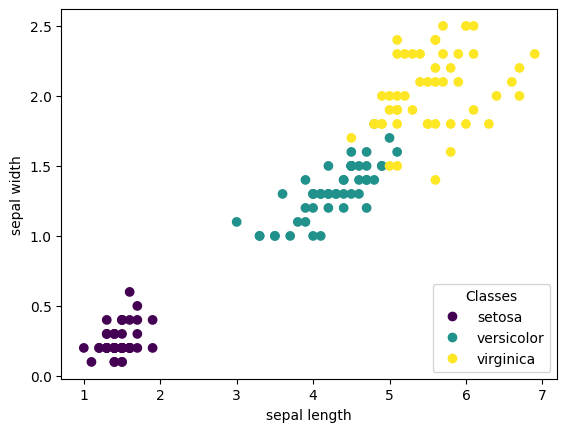

In [ ]:
#===============================
# Iris 3 classes
#===============================

iris   = datasets.load_iris()
X_iris = iris.data[:, 2:]  # just the 2 last features
Y_iris = iris.target

scatter = plt.scatter(X_iris[:, 0], X_iris[:, 1], c=Y_iris)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend(scatter.legend_elements()[0], iris.target_names, loc='lower right', title='Classes')
plt.show()

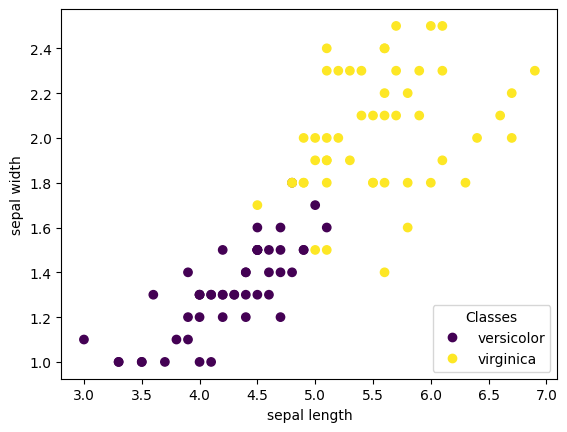

In [ ]:
#===============================
# Iris 2 classes
#===============================

# delete the 50 first samples == "setosa"
X_irisBin = np.array(X_iris[51:, :])
Y_irisBin = np.array(Y_iris[51:])

# The remaining classes have the labels: "1" and "2"
# So, transform them to "0" and "1"
msk             = Y_irisBin == 1
Y_irisBin[ msk] = 0
Y_irisBin[~msk] = 1

scatter = plt.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend(scatter.legend_elements()[0], iris.target_names[1:], loc='lower right', title='Classes')
plt.show()


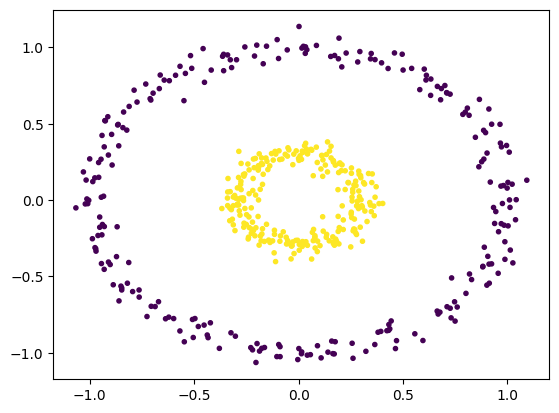

In [ ]:
#===============================
# Circles 2 classes
#===============================

# generating data
X_circle, Y_circle = make_circles(n_samples = 500, noise = 0.05, factor=0.3)

# visualizing data
plt.scatter(X_circle[:, 0], X_circle[:, 1], c = Y_circle, marker = '.')
plt.show()

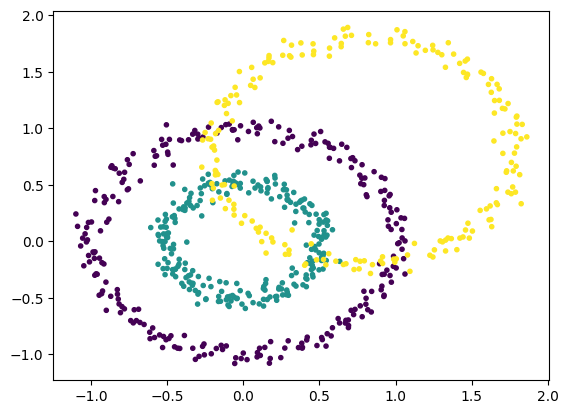

In [ ]:
#===============================
# Circles 3 overlapped classes
#===============================

# generating data
X_circle2, Y_circle2 = make_circles(n_samples = 500     , noise = 0.05, factor=0.5)
X_circle3, Y_circle3 = make_circles(n_samples = (200, 0), noise = 0.05, factor=0.2)

X_circle2 = np.concatenate((X_circle2, X_circle3 + 0.8), axis=0)
Y_circle2 = np.concatenate((Y_circle2, Y_circle3 + 2.0), axis=0)

# visualizing data
plt.scatter(X_circle2[:, 0], X_circle2[:, 1], c = Y_circle2, marker = '.')
plt.show()

### II.1. Stochastic Gradient Descent

We want to compare between GD and SGD in terms of cost convergence and training time.
To do this, we will compare between these methods:
- GD: Gradient Descent
- SGD: Stochastic Gradient Descent
- SGDA: Stochastic Gradient Descent with All samples

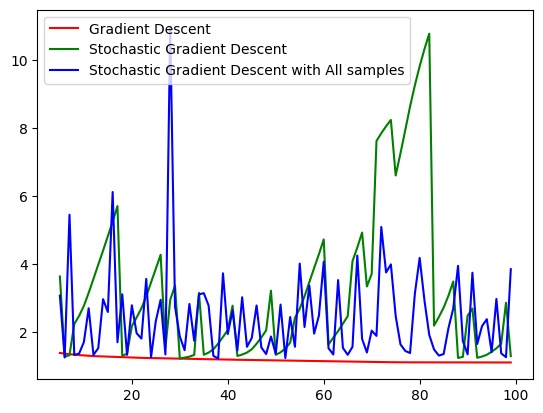

In [ ]:
# ================================================================
# This experiment depends on the previous implementation
# If you feel that your implementation may not be perfect,
#   just do not execute this cell
# ================================================================

NBR_IT = 100
ALPHA  = 0.1
C      = 10.
D_IT   = 5
Its    = range(D_IT, NBR_IT)
# Increasing the size of the dataset
# it will not affect the result in terms of convergence
# this is just to test the case with several samples
# the execution time of the "random" function in "SGD" will be negligible
X, Y = np.repeat(X_irisBin, 5, axis=0), np.repeat(Y_irisBin, 5, axis=0)

svm_gd  = SVM(IT=NBR_IT, alpha=ALPHA, C=C)
t_start = timeit.default_timer()
Js_gd   = svm_gd.fit(X, Y)
t_gd    = timeit.default_timer() - t_start

svm_sgd = SVM(IT=NBR_IT, alpha=ALPHA, C=C, solver='SGD')
t_start = timeit.default_timer()
Js_sgd  = svm_sgd.fit(X, Y)
t_sgd   = timeit.default_timer() - t_start

svm_sgda= SVM(IT=NBR_IT, alpha=ALPHA, C=C, solver='SGDA')
t_start = timeit.default_timer()
Js_sgda = svm_sgda.fit(X, Y)
t_sgda  = timeit.default_timer() - t_start



plt.plot(Its, Js_gd  [D_IT:], color='red'  , label='Gradient Descent')
plt.plot(Its, Js_sgd [D_IT:], color='green', label='Stochastic Gradient Descent')
plt.plot(Its, Js_sgda[D_IT:], color='blue' , label='Stochastic Gradient Descent with All samples')
plt.legend()
plt.show()

In [ ]:
# ================================================================
# This experiment depends on the previous implementation
# If you feel that your implementation may not be perfect,
#   just do not execute this cell
# ================================================================

pd.DataFrame({
    'Criteria': ['Train time'],
    'GD'      : [t_gd        ],
    'SGD'     : [t_sgd       ],
    'SGDA'    : [t_sgda      ],
})

,Criteria,GD,SGD,SGDA
0,Train time,0.005665,0.004207,0.965408


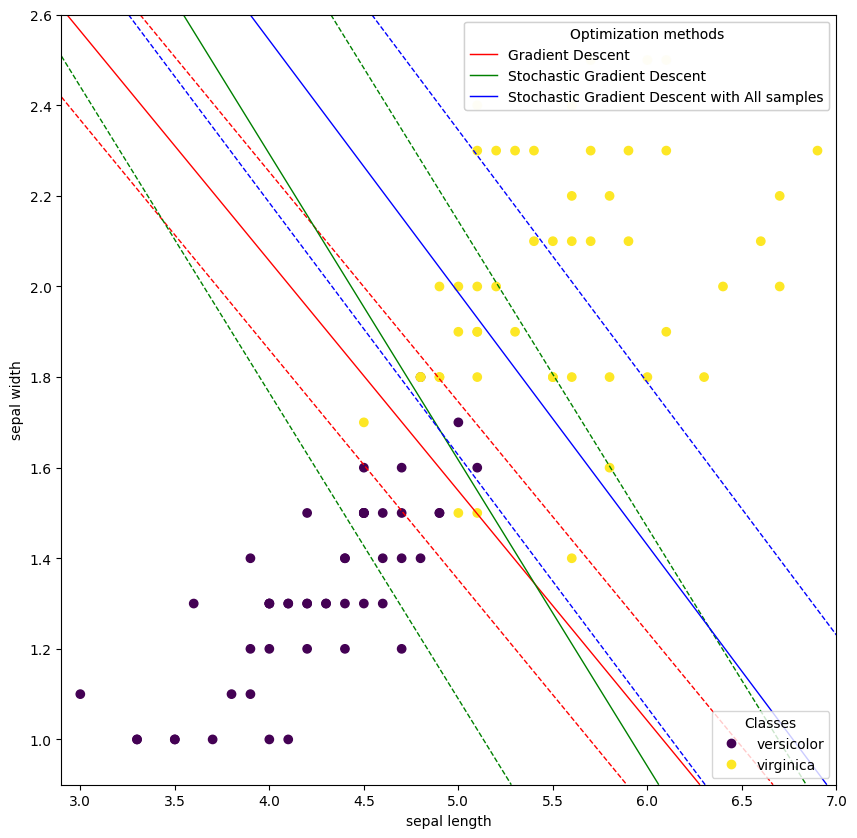

In [ ]:
# ================================================================
# This experiment depends on the previous implementation
# If you feel that your implementation may not be perfect,
#   just do not execute this cell
# ================================================================

def draw(model, ax, xx, xy, color="r", label=""):

    # create a grid with estimates on xx and xy
    grid = [[model.predict(np.array([[xr, yr]]), cls=False) for xr in xx] for yr in xy]
    # transform this grid into a matrix
    grid = np.array(grid).reshape(len(xx), len(xy))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xx, xy, grid, levels=[-1,0,1], linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=color)
    return Line2D([0, 1], [0, 0], linewidth=1, linestyle='-', color=color)


fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
legend1 = plt.legend(scatter.legend_elements()[0], iris.target_names[1:], loc='lower right', title='Classes')


# generate 100 points between the min and the max of attribute X[0]
xx = np.linspace(X_irisBin[:,0].min() - .1, X_irisBin[:,0].max() + .1, 100)
# generate 100 points between the min and the max of attribute X[1]
xy = np.linspace(X_irisBin[:,1].min() - .1, X_irisBin[:,1].max() + .1, 100)

mthds = []
mthds.append(draw(svm_gd  , ax, xx, xy, color='red'  ))
mthds.append(draw(svm_sgd , ax, xx, xy, color='green'))
mthds.append(draw(svm_sgda, ax, xx, xy, color='blue' ))

mthds_lbl = [
    'Gradient Descent',
    'Stochastic Gradient Descent',
    'Stochastic Gradient Descent with All samples'
]
legend2 = plt.legend(mthds, mthds_lbl, loc='upper right', title='Optimization methods')
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.show()

**TODO: Analyze the results**

1. We notice that the graph of J_GD is smooth unlike the other two. Why?
1. Does SGD show an advantage when there are local optima? How?
1. How can we make the SGD graph smoother (without changing the algorithm)?
1. We notice that the training time is of the order: t_SGD < t_GD << t_SGDA. Why?
1. We notice that the linear separation graph of SGD is close to that of GD. Will SGD converge by only increasing the number of iterations or do we need other configurations? Please specify.

**Answers**

1. Gradient Descent (GD) updates model weights in a deterministic direction by computing the gradient over the entire dataset at each iteration. This leads to smooth and gradual changes in the loss function J over time. In contrast, Stochastic Gradient Descent (SGD) updates weights using individual samples, introducing random fluctuations in the direction of the gradient due to the inherent variability in single observations.

1. Yes, the stochastic nature of SGD can be advantageous in non-convex optimization landscapes. Since it uses only a randomly selected data point (or mini-batch) per iteration, SGD introduces randomness into the optimization process. This can allow it to escape shallow local minima or saddle points by "jumping" to different regions of the parameter space. In contrast, GD always follows the exact steepest descent direction, which may lead it to get stuck in local minima in non-convex problems.

1. To make the SGD curve smoother, one can:

     - Use a smaller learning rate: Lowering the step size reduces the risk of large, erratic parameter updates, which in turn smooths the loss trajectory. However, it may also slow down convergence.

     - Increase the batch size: Rather than using a single sample, training with a mini-batch (multiple samples per update) reduces variance in the gradient estimate. This helps stabilize updates and produces a smoother cost curve—though at the cost of longer computation per step.

1. SGD is faster because it performs one update per sample (or mini-batch), requiring minimal computation at each step. In contrast, GD performs one update per full pass over the dataset, resulting in heavier computations per iteration. SGD with adaptive learning rate (SGDA) involves additional operations (e.g., gradient history tracking or scaling), which introduce computational overhead, making it slower than basic SGD.

1. Increasing the number of iterations can help SGD converge, especially for small or clean datasets. However, this alone is often not sufficient. Convergence depends on additional factors, such as:

    - A well-tuned or decaying learning rate to reduce instability over time,

    - The use of momentum to dampen oscillations and accelerate convergence,

    - And regularization techniques to avoid overfitting or divergence.
These strategies are essential for ensuring that SGD achieves stable and effective convergence, particularly in larger or more complex learning problems.



### II.2. "primal" vs. "dual" forms

In this experiment, we want to compare the two forms "primal" and "dual" in the context of binary classification.
This is why we trained two models:
- svm_primal
- svm_dual

To compare these models, we used these criteria:
- Training time
- Prediction time
- Model size

In [ ]:
# ================================================================
# This experiment depends on the previous implementation
# If you feel that your implementation may not be perfect,
#   just do not execute this cell
# ================================================================

ALPHA = 0.1
C     = 10.

# Increasing the size of the dataset
# it will not affect the result in terms of convergence
# this is just to test the case with several samples
# the execution time of the "random" function in "SGD" will be negligible
X, Y = np.repeat(X_irisBin, 5, axis=0), np.repeat(Y_irisBin, 5, axis=0)

primal_stats = []
dual_stats   = []

#=========== PRIMAL =======================
svm_primal = SVM(IT=10, alpha=ALPHA, C=C)
t_start    = timeit.default_timer()
svm_primal.fit(X, Y)
primal_stats.append(timeit.default_timer() - t_start)
#-------------------------------------------
t_start    = timeit.default_timer()
Y_primal   = svm_primal.predict(X)
primal_stats.append(timeit.default_timer() - t_start)
#-------------------------------------------
primal_stats.append(get_size(svm_primal))
#-------------------------------------------
#primal_stats.append(accuracy_score(Y, Y_primal))

#=========== DUAL =======================
svm_dual   = SVM(dual=True, C=C, tol = 0.001)
t_start    = timeit.default_timer()
svm_dual.fit(X, Y)
dual_stats.append(timeit.default_timer() - t_start)
#-------------------------------------------
t_start    = timeit.default_timer()
Y_dual     = svm_dual.predict(X)
dual_stats.append(timeit.default_timer() - t_start)
#-------------------------------------------
dual_stats.append(get_size(svm_dual))
#-------------------------------------------
#dual_stats.append(accuracy_score(Y, Y_dual))

pd.DataFrame({
    'Criteria' : ['Train time', 'Prediction time', 'Size'], #, "Accurracy train"
    'Primal'  : primal_stats,
    'Dual'    : dual_stats,
})

,Criteria,Primal,Dual
0,Train time,0.002126,5.752770
1,Prediction time,0.000072,0.002494
2,Size,2470.000000,50812.000000


**TODO: Analyze the results**

1. We notice that TrainTime(svm_primal) << TrainTime(svm_dual). Why?
1. We notice that PredTime(svm_primal) << PredTime(svm_dual). Why?
1. We notice that Size(svm_primal) << Size(svm_dual). Why (detail)?
1. It seems that the "dual" form is bad based on these criteria, in this case, why is it used?

**Answers**

1. The dual training time (5.75s) is ~2700× slower than primal (0.002s), suggesting either many training samples or a complex kernel was used.

    The primal form solves the optimization problem directly in the original feature space, which is computationally simpler for linear SVMs with many samples. It typically uses efficient gradient descent methods.

    The dual form requires solving a quadratic programming problem involving the kernel matrix (n×n where n is number of samples), which has O(n³) complexity. For large datasets, this becomes prohibitively expensive.
1. Primal SVM makes predictions using a simple dot product: f(x) = w·x + b, where w is typically dense but low-dimensional.

    Dual SVM requires evaluating kernel functions with support vectors: f(x) = Σα_i y_i K(x_i, x) + b. This sum grows with the number of support vectors (often proportional to training set size).
1. Primal stores only the weight vector w (dimension d) and bias b.

    Dual must store all support vectors (typically a substantial fraction of training data) and their coefficients. Kernelized SVMs also need to store kernel parameters, further increasing memory usage.
1. Dual form enables nonlinear decision boundaries via kernels (RBF, polynomial, etc.), while primal cannot. This is crucial for many real-world problems.

### II.3. C parameter

To test the effect of the C hyper-parameter, we will use **sklearn.svm.SVC** which is based on **LIBSVC** (SMO: Sequential minimal optimization). We noticed that the execution time is not stable in each execution. So, the idea to fix this is to run the same experiment over several trials and try to keep the average times.

So, to test the effect of parameter C, we drew 2 diagrams:
- The prediction margins for some values of C (on binary Iris, to better visualize the separation)
- Training time compared to C values (on Iris 3 classes, to have more data)

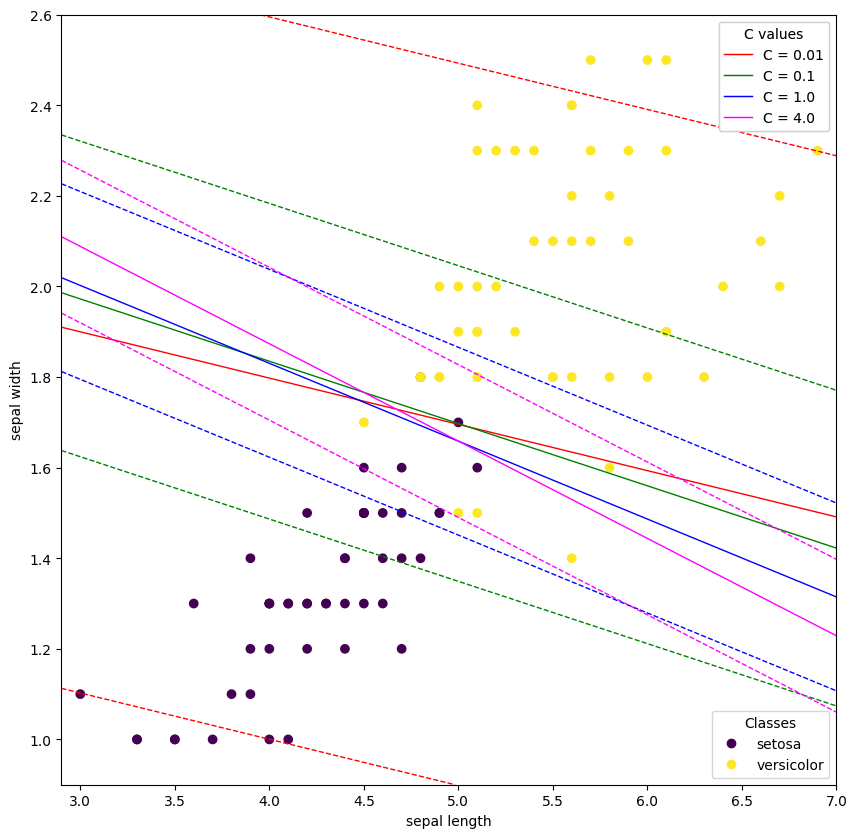

In [ ]:
def draw_sklearn0(model, ax, xx, xy, color='r', label=''):

    Z    = model.decision_function(np.array(np.meshgrid(xx, xy)).T.reshape(-1, 2))
    grid = np.array(Z).reshape(len(xx), len(xy))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xx, xy, grid, levels=[-1,0,1], linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=color)
    return Line2D([0, 1], [0, 0], linewidth=1, linestyle='-', color=color)

fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(X_irisBin[:, 0], X_irisBin[:, 1], c=Y_irisBin)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
legend1 = plt.legend(scatter.legend_elements()[0], iris.target_names, loc='lower right', title='Classes')

# generate 100 points between the min and the max of attribute X[0]
xx = np.linspace(X_irisBin[:,0].min() - .1, X_irisBin[:,0].max() + .1, 100)
# generate 100 points between the min and the max of attribute X[1]
xy = np.linspace(X_irisBin[:,1].min() - .1, X_irisBin[:,1].max() + .1, 100)

Csp       = [0.01, 0.1, 1., 4.]
mthds     = []
mthds_lbl = []
Couleurs  = ['red', 'green', 'blue', 'magenta']

for Cp, couleur in zip(Csp, Couleurs):
    modele = SVC(C=Cp, kernel='linear', random_state=0, probability=True)
    modele.fit(X_irisBin, Y_irisBin)
    a = draw_sklearn0(modele, ax, xx, xy, color=couleur)
    mthds.append(a)
    mthds_lbl.append('C = ' + str(Cp))

legend2 = plt.legend(mthds, mthds_lbl, loc='upper right', title='C values')
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.show()

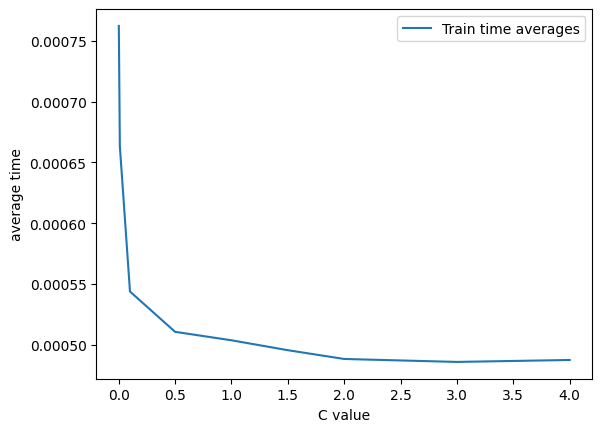

In [ ]:
TRIALS = 50

X, Y = np.repeat(X_iris, 1, axis=0), np.repeat(Y_iris, 1, axis=0)
#X, Y = X_circle2, Y_circle2

# normalisateur = StandardScaler()
# X = normalisateur.fit_transform(X)

Cs       = [0.001, 0.01, 0.1, 0.5, 1., 1.5, 2., 3, 4]
Tr_stats = []

for tr in range(TRIALS):
    Cs_stats = []
    Tr_stats.append(Cs_stats)
    for C in Cs:
        modele      = SVC(C=C, kernel='linear', random_state=0)
        temps_debut = timeit.default_timer()
        modele.fit(X, Y)
        Cs_stats.append(timeit.default_timer() - temps_debut)


Temps_moy = np.mean(Tr_stats, axis=0)
plt.plot(Cs, Temps_moy, label='Train time averages')
plt.xlabel('C value')
plt.ylabel('average time')
plt.legend()
plt.show()


**TODO: Analyze the results**

1. What is the effect of C hyper-parameter on the prediction margins?
1. We notice (in general) that the training time decreases with large values of **C**. How **C** can affect this time?

**Answers**

1.
As C increases (from 0.01 → 4.0 in your plot), the margin narrows (margin width decreases from ~2.4 to ~1.0).
*   Small C (e.g., 0.01): Prioritizes a wide margin, allowing some misclassifications (soft margin).
Result: Larger margin, lower model complexity, better generalization (if data is noisy).
*   Large C
(e.g., 4.0): Prioritizes correct classification, penalizing misclassified points heavily.
Result: Narrower margin, potential overfitting to training data.



2.
Training time decreases as C increases (from ~0.00075s at C=0.01 to ~0.0005s at C=4.0).


*   Small C:
The optimizer allows more margin violations (slack variables), leading to a more constrained problem.
Requires more iterations to balance margin width and errors.
*   Large C:
The SVM focuses on classifying points correctly, reducing the feasible solution space.
The problem becomes "easier" to solve (fewer trade-offs to consider), speeding up convergence.









### II.4. Kernel choice

In this experiment, we want to test the effect of kernel choice for a certain problem. We will use multiclass Iris dataset where kernels will be evalued based on:
- Model separation (visualization)
- F-1 convergence score
- Training time

Used kernels are:
- **linear**: a linear kernel
- **poly**: a polynomial kernel with a degree 4
- **rbf**: a radial core (Radial Basis Function)
- **cosine**: a kernel with cosine similarity between samples

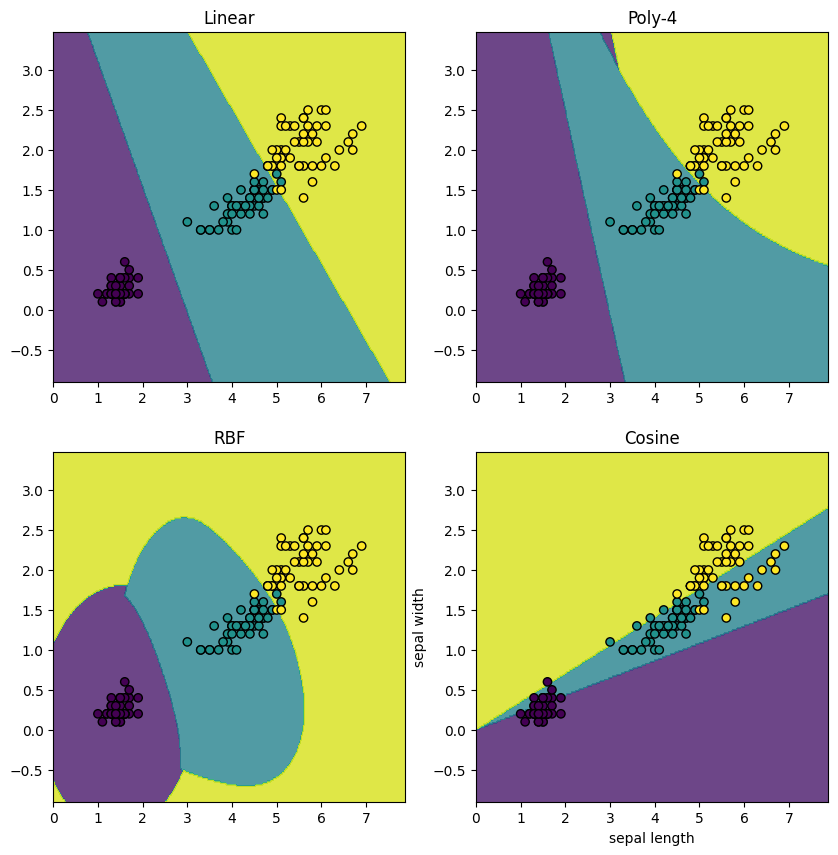

In [ ]:
# Test inspired by https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html

def draw_sklearn(model, ax, xx, xy, X, Y, label=""):

    Z   = model.predict(np.c_[xx.ravel(), xy.ravel()])
    Z   = Z.reshape(xx.shape)
    out = ax.contourf(xx, xy, Z, alpha=0.8)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k')
    plt.xlabel('sepal length')
    plt.ylabel('sepal width')
    ax.set_title(label)



models = [
    SVC(kernel='linear'         , random_state=0, probability=True           ),
    SVC(kernel='poly'           , random_state=0, probability=True, degree=4 ),
    SVC(kernel='rbf'            , random_state=0, probability=True, gamma=0.7),
    SVC(kernel=cosine_similarity, random_state=0, probability=True           ),
]

labels = [
    'Linear',
    'Poly-4',
    'RBF'   ,
    'Cosine'
]

temps_kernel = []


fig, axs = plt.subplots(2, 2, figsize=(10,10))


xx_min, xx_max = X_iris[:, 0].min() - 1, X_iris[:, 0].max() + 1
xy_min, xy_max = X_iris[:, 1].min() - 1, X_iris[:, 1].max() + 1
xx, xy = np.meshgrid(np.arange(xx_min, xx_max, .02), np.arange(xy_min, xy_max, .02))

for model, label, ax in zip(models, labels, axs.flatten()):
    temps_debut = timeit.default_timer()
    model.fit(X_iris, Y_iris)
    temps_kernel.append(timeit.default_timer() - temps_debut)
    draw_sklearn(model, ax, xx, xy, X_iris, Y_iris, label=label)

plt.show()

In [ ]:
perf = []

for model in models:
    perf.append(f1_score(Y_iris, model.predict(X_iris), average='micro'))

pd.DataFrame({
    'Kernel'        : labels,
    'Train F1 score': perf,
    'Train time'    : temps_kernel
})

,Kernel,Train F1 score,Train time
0,Linear,0.966667,0.002452
1,Poly-4,0.960000,0.001451
2,RBF,0.966667,0.001431
3,Cosine,0.780000,0.001761


**TODO: Analyze the results**

1. Based on the decision lines and the F1-score, what is the best kernel for this problem in your opinion?
1. Why?

**Answers**

1. RBF (Radial Basis Function) is the best kernel for this problem.
1. Why ?
 - F1-Score: The RBF kernel achieves the highest possible score (0.966667), equal to the Linear kernel and slightly better than Poly-4 (0.960000).

 - Training Time: RBF is the fastest among the top-performing kernels (only 0.001431s).

 - Generalization: RBF is a non-linear kernel that adapts well to complex data boundaries.
If the decision boundary is not strictly linear, RBF can capture the structure better than Linear, while avoiding the possible overfitting of higher-degree polynomials.

 Even though Linear performs equally well in this specific metric, RBF is more flexible and robust if the data includes non-linear patterns — and it does so faster than Linear here.

### II.5. Problem complexity

Here, we want to test the effect of the complexity of the problem on the separation, as well as the parameterization. We will use the **RBF** kernel which is more flexible and which supports more complex problems (non-linearly separable). We will use two criteria in this experiment:
- F1-convergence score
- Separation between classes (visualization)

The addressed problems are:
- **Iris**: linear separation between 3 classes
- **Iris 2 classes**: binary linear separation
- **Circle 2 classes**: binary radial separation
- **3-class circle with overlap**: radial separation, but with overlap between classes (here, slightly different configuration for RBF)

In [ ]:
rbf2 = SVC(kernel='rbf', random_state=0, gamma=0.7, probability=True)
rbf3 = SVC(kernel='rbf', random_state=0, gamma=0.7, probability=True)
rbf4 = SVC(kernel='rbf', random_state=0, gamma=10., probability=True)

rbf2.fit(X_irisBin, Y_irisBin)
rbf3.fit(X_circle , Y_circle )
rbf4.fit(X_circle2, Y_circle2)

perf2 = []
perf2.append(f1_score(Y_iris   , models[2].predict(X_iris) , average='micro'))
perf2.append(f1_score(Y_irisBin, rbf2.predict(X_irisBin)   , average='micro'))
perf2.append(f1_score(Y_circle , rbf3.predict(X_circle)    , average='micro'))
perf2.append(f1_score(Y_circle2, rbf4.predict(X_circle2)   , average='micro'))

pd.DataFrame({
    'Problem'  : ['Iris', 'Iris 2 classes', 'Circles', 'Circles 3 classes'],
    'F1 train' : perf2
})

,Problem,F1 train
0,Iris,0.966667
1,Iris 2 classes,0.949495
2,Circles,1.000000
3,Circles 3 classes,0.948571


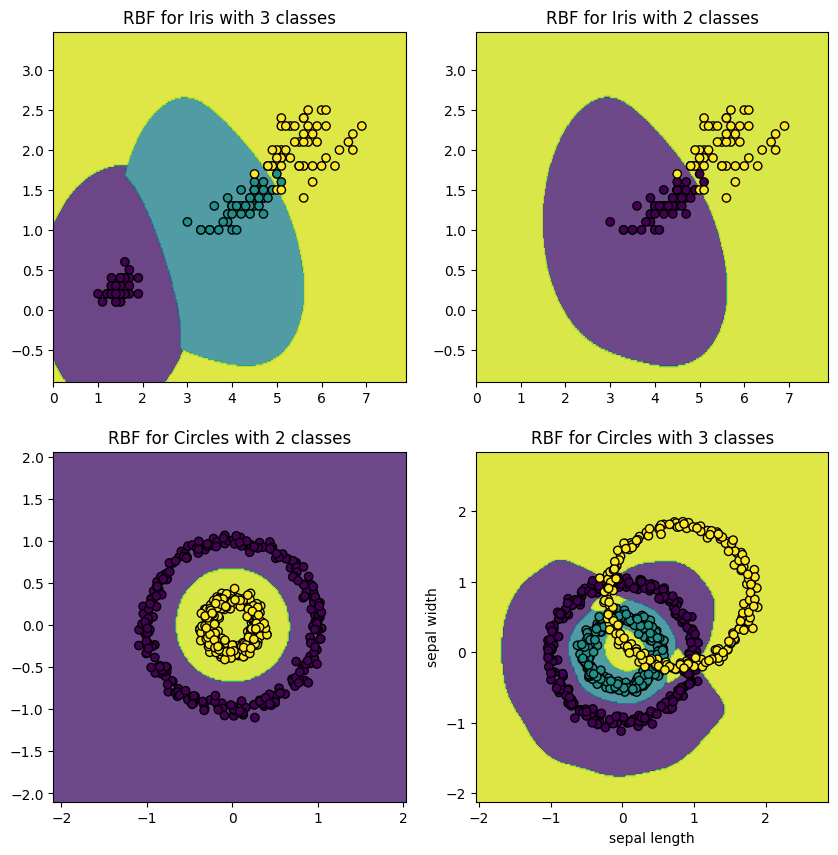

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))


draw_sklearn(models[2], ax1, xx, xy, X_iris, Y_iris, label='RBF for Iris with 3 classes')
draw_sklearn(rbf2, ax2, xx, xy, X_irisBin, Y_irisBin, label='RBF for Iris with 2 classes')

xx_min3, xx_max3 = X_circle[:, 0].min() - 1, X_circle[:, 0].max() + 1
xy_min3, xy_max3 = X_circle[:, 1].min() - 1, X_circle[:, 1].max() + 1
xx3, xy3 = np.meshgrid(np.arange(xx_min3, xx_max3, .02), np.arange(xy_min3, xy_max3, .02))
draw_sklearn(rbf3, ax3, xx3, xy3, X_circle, Y_circle, label='RBF for Circles with 2 classes')

xx_min4, xx_max4 = X_circle2[:, 0].min() - 1, X_circle2[:, 0].max() + 1
xy_min4, xy_max4 = X_circle2[:, 1].min() - 1, X_circle2[:, 1].max() + 1
xx4, xy4 = np.meshgrid(np.arange(xx_min4, xx_max4, .02), np.arange(xy_min4, xy_max4, .02))
draw_sklearn(rbf4, ax4, xx4, xy4, X_circle2, Y_circle2, label='RBF for Circles with 3 classes')

plt.show()

**TODO: Analyze the results**

1. Why does the model converge better on "Circle 2 classes" despite the fact that it is a more complex problem than the two linearly separable problems?
1. Why does the model give a better F1-score on "Iris" than "Iris 2 classes" despite the latter being a simpler problem?

**Answers**

1. RBF excels at nonlinear patterns it was designed for, even if they appear more complex visually.
The model performs best on the 2-class circles problem because the RBF kernel is perfectly suited for circular decision boundaries, and the data is clean and well-separated.
1. *   Class Overlap:
The 2-class subset likely includes overlapping species (e.g., versicolor and virginica), making separation harder.
The 3-class problem may leverage multiclass margins that indirectly improve pairwise separation.

   *   Data Efficiency:
More classes provide richer geometric cues for the kernel to generalize better.
2-class subsets might isolate problematic pairs.





In [1]:
print('Yay! 5 out of 7 labs have been done.')

Yay! 5 out of 7 labs have been done.
